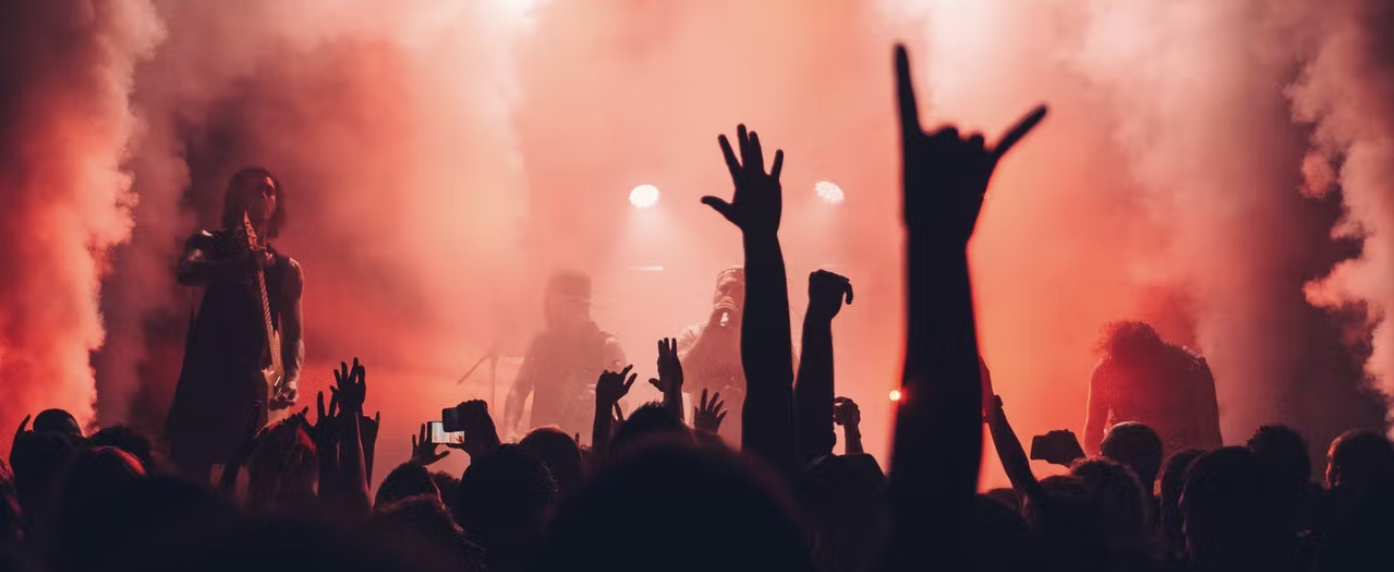

# Spotify

**Author:** Dermot O'Brien
***

## Overview

60,000 songs are uploaded to spotifys platform daily, giving spotify early access to data unseen by other interested parties. Spotify’s largest expenses come from the licencing cots paid to the major record labels that allow spotify to stream their clients music. If spotify were able to recgonize talent on their own using data only available to them, they could potentially create their own record label, sign artists with high potential, and reduce/avoid the high licensing costs paid to labels. If changing their business model is too large of a task, they can at the very least understand which songs and artists to back up with funding and team support to maximize streams and optimize resource allocation. 

## Business Problem

To ensure the success of spotify’s own label, they need to be able to instantaneously - on first upload to the database - whether or not a song will be a success. As a consultant of spotify, I will work to create a model that can be used by Spotify that recgonizes those high-potential hit songs based on spotifys own data - specifically audio features and spotify-specific features. 

## I. Data Importing and Dataframe Creation
To create the dataframe used for modeling, three steps will be required. First, I will need to pull a list of id's from Kaggle's [Every Noise at Once Dataset](https://www.kaggle.com/datasets/nikitricky/every-noise-at-once/discussion?select=songs.csv) that can pass through Spotify's API. Note that I will only be using data between January 2020 and September 2021 for relevance purposes. Next, I will pass the list of id's through spotipy's `.audio_features` method and create a features dataframe. Finally, I'll pass the list of id's through spotipy's `.tracks` method to create a popularity dataframe. After concatenating these two dataframes, we will have a comprehensive dataframe to begin our analysis. For a cleaner notebook, I've created the features and popularity dataframes in an alternate notebook.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import base64
import requests
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import MissingIndicator
import xgboost as xgb
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

%matplotlib inline

### Spotify API token creation

In [2]:
# Create variables for client id and client secret to create token
cid = 'fe9b61dd4aea4998a73a7e7f095bb66a'
secret = '8544bf1566dd4f3c8b5f80f032d9617e'

In [3]:
# Spotipy authorization steps
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Dataframe Creation
To create the features and popularity dataframes, I first needed to use for loops to retreive the data since spotify's api can only pull 50-100 rows at a time depending on the method. Since the `.tracks` method's output is a messy lists of dictionaries, we'll need a nested for loop. For documentation, please refer to the *Kaggle Investigation* notebook. The final dataframe before eda and data prep, labeled df, will be a concat of popularity_df and features_df. 

In [4]:
# Pull the dataframes created in the Kaggle Investigation Notebook
popularity_df = pd.read_csv('./Data/target_df')
features_df = pd.read_csv('./Data/features_df')

In [5]:
# Drop duplicates in features_df
features_df.drop_duplicates(subset=['id'], inplace=True)

In [6]:
# Merge dataframes on id
df = pd.merge(features_df, popularity_df, on ='id')

Due to the merge, we have roughly 20,000 rows with no popularity values. We'll go ahead and drop those before EDA

In [7]:
# Check for 0 values in popularity column
df[df['popularity'] == 0].shape

(20040, 19)

In [8]:
# Drop columns from popularity column with values of 0
df = df[df.popularity != 0]

## II. Data Understanding


### Column Names and Understanding
* `danceability`: [str] Describes how suitable a track is for dancing. A value of 0.0 is least danceable and 1.0 is most danceable.
* `energy`: [float] Represents a perceptual measure of intensity and activity. A measure from 0.0 to 1.0.
* `key`: [int] The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
* `loudness`: [float] The overall loudness of a track in decibels (dB). Values typically range between -60 and 0 db.
* `mode`: [int] Modality of a track. Major is represented by 1 and minor is 0.
* `speechiness`: [float] Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* `accousticness`: [float] A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* `instrumentalness`: [float] Predicts whether a track contains no vocals. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* `liveness`: [float] Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* `valence`: [float] A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive.
* `tempo`: [float] The overall estimated tempo of a track in beats per minute (BPM).
* `type`: [str] The object type (audio_features)
* `id`: [str] The Spotify ID for the track.
* `uri`: [str] The Spotify URI for the track.
* `track_href`: [str] A link to the Web API endpoint providing full details of the track.
* `analysis_url`: [str] A URL to access the full audio analysis of this track. An access token is required to access this data.
* `duration_ms`: [int] The duration of the track in milliseconds.
* `time_signature`: [int] An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
* `popularity`: [int] The target variable. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

Let's start by examining the data to see how it can be cleaned. Odds are we won't need all of the columns mentioned above, some having little useful information and others being descriptive and non-numeric.

In [9]:
# Check the shape of the df
df.shape

(66045, 19)

In [10]:
# Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66045 entries, 0 to 86084
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      66045 non-null  float64
 1   energy            66045 non-null  float64
 2   key               66045 non-null  int64  
 3   loudness          66045 non-null  float64
 4   mode              66045 non-null  int64  
 5   speechiness       66045 non-null  float64
 6   acousticness      66045 non-null  float64
 7   instrumentalness  66045 non-null  float64
 8   liveness          66045 non-null  float64
 9   valence           66045 non-null  float64
 10  tempo             66045 non-null  float64
 11  type              66045 non-null  object 
 12  id                66045 non-null  object 
 13  uri               66045 non-null  object 
 14  track_href        66045 non-null  object 
 15  analysis_url      66045 non-null  object 
 16  duration_ms       66045 non-null  int64 

In [11]:
# Check the statistics of numerical columns
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
count,66045.000000,66045.000000,66045.00000,66045.000000,66045.000000,66045.000000,66045.000000,66045.000000,66045.000000,66045.000000,66045.000000,6.604500e+04,66045.000000,66045.000000
mean,0.595497,0.635435,5.30673,-8.567336,0.576622,0.101893,0.285464,0.204847,0.183175,0.453260,122.413112,2.326026e+05,3.920282,20.846847
std,0.189874,0.238108,3.57791,4.925100,0.494098,0.098069,0.311962,0.344674,0.143367,0.253812,29.253738,9.354251e+04,0.397993,16.860289
min,0.000000,0.000221,0.00000,-53.885000,0.000000,0.000000,0.000000,0.000000,0.011300,0.000000,0.000000,3.163200e+04,0.000000,1.000000
25%,0.473000,0.487000,2.00000,-10.137000,0.000000,0.039100,0.015300,0.000000,0.097100,0.242000,99.889000,1.770370e+05,4.000000,5.000000
50%,0.620000,0.660000,5.00000,-7.526000,1.000000,0.058700,0.155000,0.000205,0.123000,0.442000,122.016000,2.113420e+05,4.000000,17.000000
75%,0.742000,0.828000,8.00000,-5.566000,1.000000,0.125000,0.496000,0.286000,0.227000,0.653000,140.070000,2.610960e+05,4.000000,33.000000
max,0.985000,1.000000,11.00000,5.968000,1.000000,0.966000,0.996000,1.000000,0.986000,0.991000,236.196000,2.441813e+06,5.000000,89.000000


### Danceability

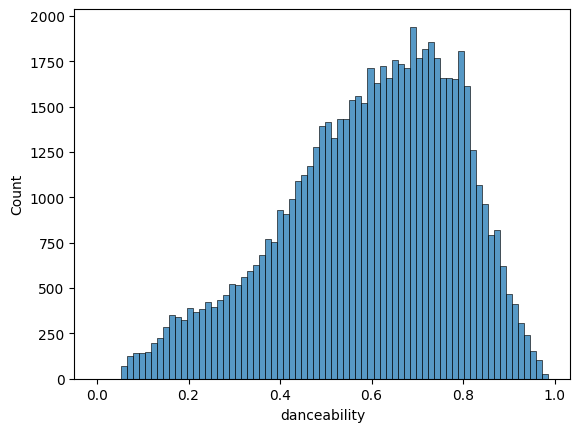

In [12]:
sns.histplot(df.danceability);

### Energy

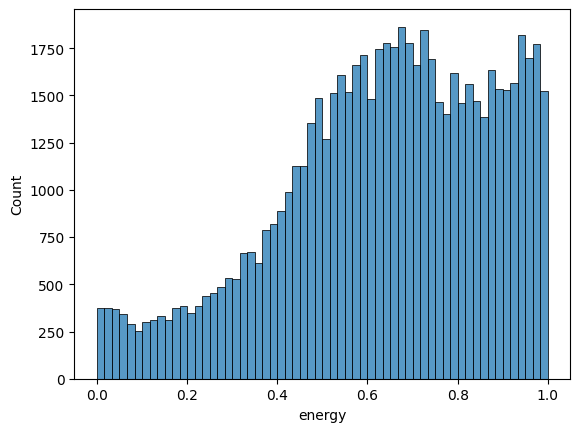

In [13]:
sns.histplot(df.energy);

### Key

In [14]:
df.key.value_counts(normalize=True, ascending=False)

1     0.115573
7     0.108971
0     0.104580
2     0.096253
9     0.095359
11    0.085260
5     0.078159
6     0.076221
4     0.075706
8     0.066440
10    0.066409
3     0.031070
Name: key, dtype: float64

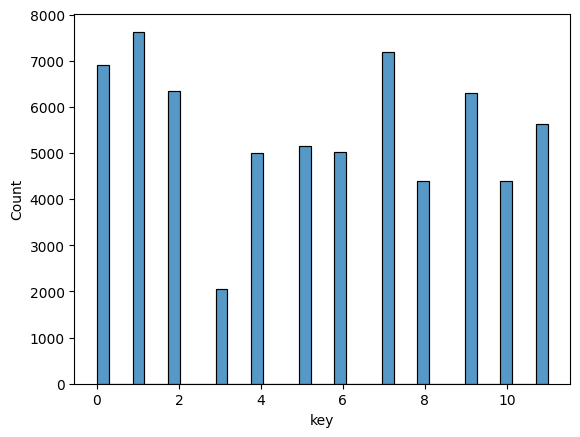

In [15]:
sns.histplot(df.key);

### Loudness

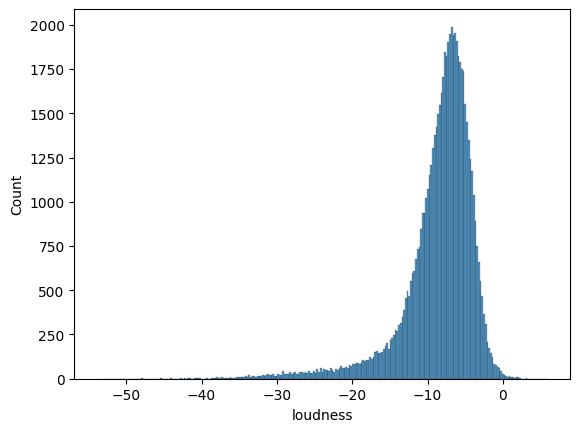

In [16]:
sns.histplot(df.loudness);

### Mode

In [17]:
# Major key = 1 and Minor key = 0
df['mode'].value_counts(normalize=True)

1    0.576622
0    0.423378
Name: mode, dtype: float64

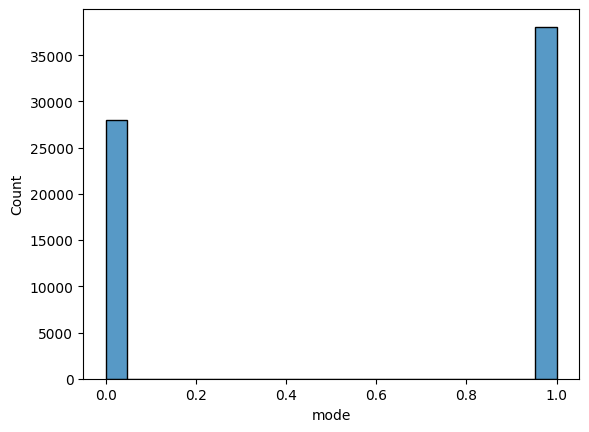

In [18]:
sns.histplot(df['mode']);

### Speechiness

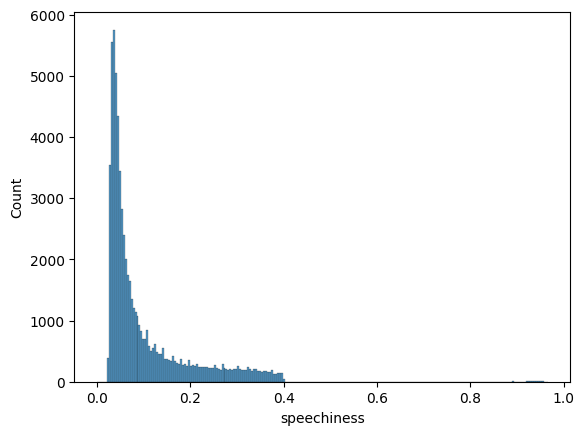

In [19]:
sns.histplot(df.speechiness);

### Acousticness

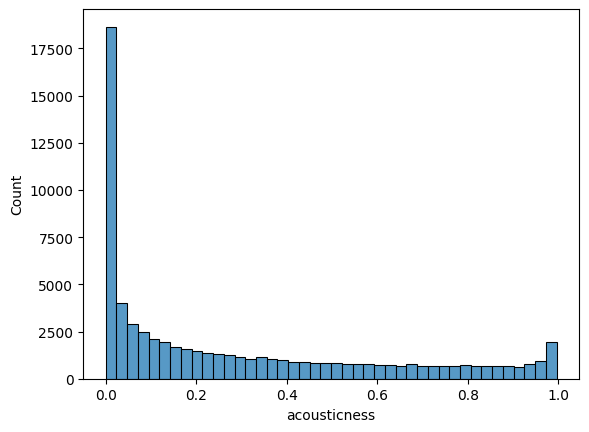

In [20]:
sns.histplot(df.acousticness);

### Instrumentalness

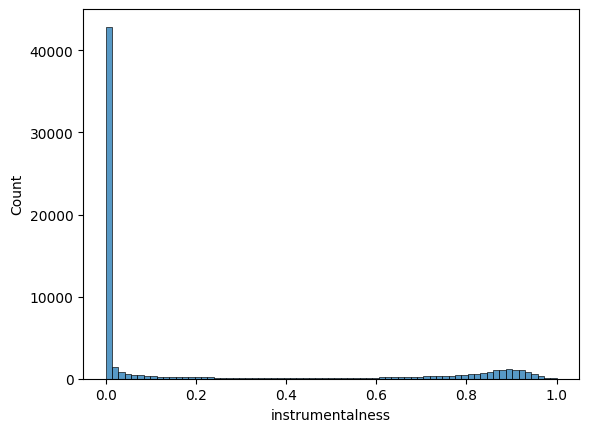

In [21]:
sns.histplot(df.instrumentalness);

### Liveness

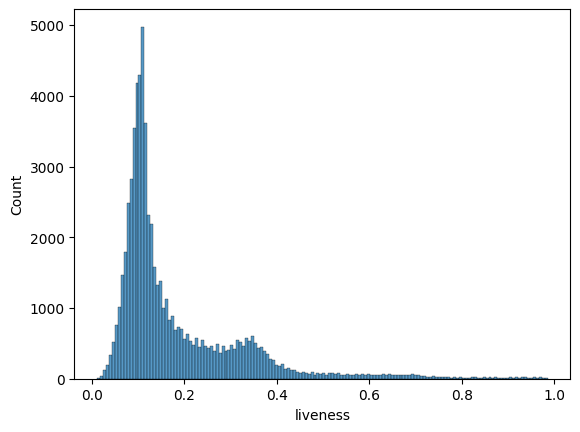

In [22]:
sns.histplot(df.liveness);

### Valence

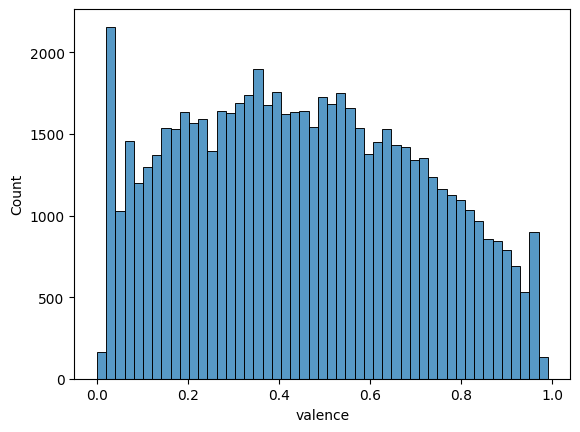

In [23]:
sns.histplot(df.valence);

### Tempo

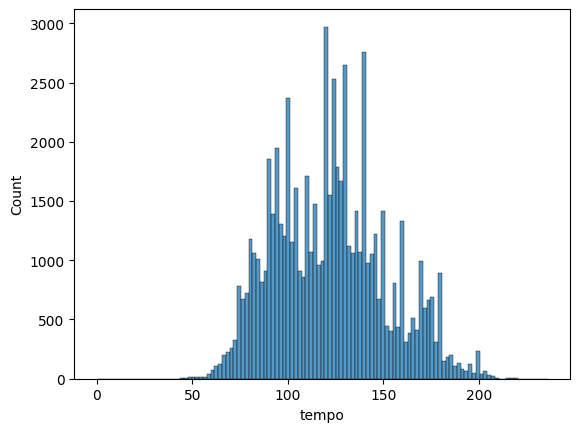

In [24]:
sns.histplot(df.tempo);

### Duration

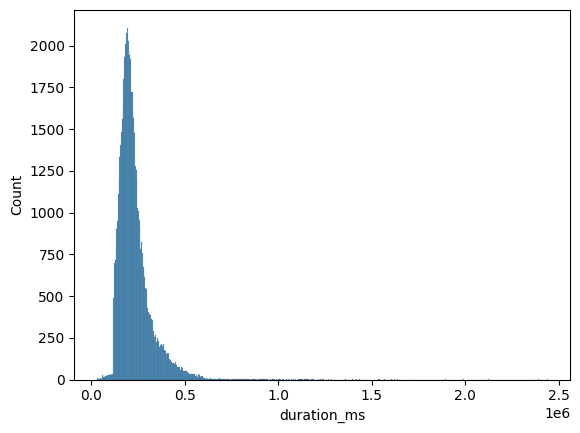

In [25]:
sns.histplot(df['duration_ms']);

### Time Signature

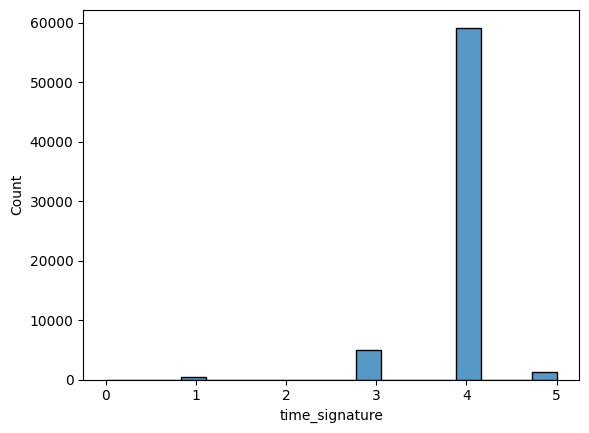

In [26]:
sns.histplot(df.time_signature);

### Popularity

In [27]:
df.popularity.value_counts(normalize=True)

1     0.085760
2     0.057582
3     0.044046
4     0.035415
5     0.029374
        ...   
84    0.000061
87    0.000045
88    0.000015
89    0.000015
86    0.000015
Name: popularity, Length: 89, dtype: float64

In [28]:
df[df['popularity'] == 1].shape

(5664, 19)

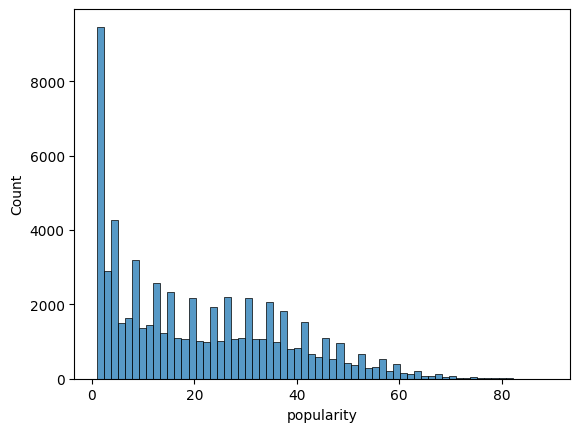

In [29]:
sns.histplot(df.popularity);

In [30]:
test_df = df[df['popularity'] > 4]

In [31]:
test_df.shape

(51330, 19)

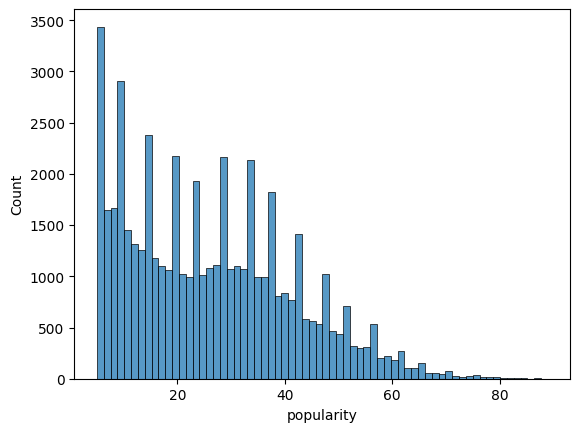

In [32]:
sns.histplot(test_df.popularity);

## III. Data Preparation
When checking the data, a common scenario occured where a song that was first released as a single and later put on an album were getting extremey low scores, possibly because spotify separates data on the single vs on an album. To ensure those album songs arent getting tracked, we will remove the very low scores, which I classified as songs with a popularity score less than 5.

We'll then need to add a binary column that indicates whether a song is a "hit" or not. This will be classified by songs with a popularity score > 50. Since were looking at older songs (Jan 2020 - Sept 2021), I lowered the threshold of popularity since the algorithim from spotify adds more weight to recent streams.

* `hit`: new column - indicates if that song is a hit or not

Let's also drop inutile columns:
* `key`: looks somewhat equally distributed
* `time_signature`: mostly all songs have a time signature of 4
* `popularity`: since we changed this to a binary (Hit or no hit), we can drop this column
* None-numeric columns to drop: `type`, `id`, `uri`, `track_href`, `analysis_url`

In [33]:
# Using drop() to delete rows based on column value
df.drop(df[df['popularity'] < 5].index, inplace=True)

In [34]:
# Check to see if that worked, should now have 51,330 rows
df.shape

(51330, 19)

In [35]:
# Create a new column for 'hit'
df['hit'] = np.where(df['popularity'] >= 50, 1, 0)

In [36]:
# Check to see if the new column works correctly
df.loc[df['popularity'] >= 50, ['hit']].min() == df.loc[df['popularity'] >= 50, ['hit']].max()

hit    True
dtype: bool

In [37]:
df.loc[df['popularity'] < 50, ['hit']].min() == df.loc[df['popularity'] < 50, ['hit']].max()

hit    True
dtype: bool

In [38]:
df.drop(['key', 
         'time_signature', 
         'popularity', 
         'type', 
         'id', 
         'uri', 
         'track_href',
         'analysis_url'], axis=1, inplace=True)

In [39]:
# Check to see if that worked, should now have 12 columns
df.shape

(51330, 12)

In [40]:
# Change duration_ms to duration_s, milliseconds to seconds conversion
df['duration_ms'] = df['duration_ms'].div(1000).round()

In [41]:
df.rename(columns={'duration_ms':'duration_s'}, inplace=True)

### Some Visualizations

In [42]:
# Visualize distributions
#for a, column in enumerate(df.columns):
#    plt.figure(a)
#    sns.histplot(df[column])

In [43]:
# Create a scatter matrix of columns to check for correlation
#sns.pairplot(df)

In [44]:
# Create a radar chart (spiderplot)

## IV. Data Modeling
Describe and justify the process for analyzing or modeling the data.

### Modeling Techniques
As we edge closer to modeling, it is important to distinguish which evaluation metric we want to focus on maximizing.  Music labels want to maximize the ability to predict a hit song correctly. It is more important that they predict a hit correctly, opposed to missing out on a song that eventually became a hit. In this instance, precision is most important to Spotify's bottom line. Remember that precision in our context evaluates how well our model correctly predicts whether a song will be a hit or not:

Precision = True positives / (True positives + False positives)

Basically, of all of our predicted hit songs, how many were actually hit songs?

Recall measures how many actual hits we predicted correctly.

Recall = True positives / (True positives + False negatives)

If we classified a song as not a hit, but then it becomes a hit (false negative), we're not losing much monetarily given we never actually invested time/resources into that song/artist. On the other hand, if we predict a song is a hit and it ends up being a flop (false positive) we have now lost a lot of time and money on a dud. The later scenario is one that we want to minimize, which is why we are focusing on precision.

### Train Test Split

In [45]:
# Create variables and split data into training and testing
X = df.drop('hit', axis=1)
y = df['hit']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Class Setup for Model Evaluation

In [60]:
# Create a Class to evaluate each model with cross validation
# This plot was taken from flatiron school's curriculum team and adapted by our team to fit our needs

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_accuracy = None
        self.cv_precision = None
        self.cv_recall = None

        # cross validate immediately when an object is created or not
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_accuracy = cross_val_score(self.model, cv_X, cv_y, cv=kfolds).mean()
        self.cv_recall = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='recall').mean()
        self.cv_precision = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='precision').mean()

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_accuracy: .5f} accuracy
            {self.cv_recall: .5f} recall
            {self.cv_precision: .5f} precision
        ''')
        print(cv_summary)

        return cv_summary

### Dummy Model

In [62]:
# Dummy Model that predicts all observations to be in the hit class
dummy_model_constant = DummyClassifier(strategy='constant', constant=1)
dummy_model_constant.fit(X_train, y_train)

DummyClassifier(constant=1, strategy='constant')

In [63]:
# Evaluate dummy constant model with CV
dummy_constant_results = ModelWithCV(model=dummy_model_constant,
                         model_name='dummy_constant_results',
                         X=X_train,
                         y=y_train)

dummy_constant_results.print_cv_summary();

CV Results for `dummy_constant_results` model:
             0.08258 accuracy
             1.00000 recall
             0.08258 precision
        


In [66]:
# Dummy Model that predicts all observations to be in the class with the most frequent values (not a hit)
dummy_model_mf = DummyClassifier(strategy='most_frequent', constant=1)
dummy_model_mf.fit(X_train, y_train)

DummyClassifier(constant=1, strategy='most_frequent')

In [69]:
# Evaluate dummy mf model with CV
dummy_mf_results = ModelWithCV(model=dummy_model_mf,
                         model_name='dummy_mf_results',
                         X=X_train,
                         y=y_train)

dummy_mf_results.print_cv_summary();

CV Results for `dummy_mf_results` model:
             0.91742 accuracy
             0.00000 recall
             0.00000 precision
        


/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### Pipeline Setup

Creating this pipeline will allow us to make changes in a more efficient manner, simplifying the process of itereating models and tuning individual pipelines as needed.

In [70]:
# Create pipelines for missing indicator, numeric and categorical to fit into Categorical Transformer.
num_pipeline = Pipeline(steps=[ ('mms', MinMaxScaler())])
cat_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [71]:
# The "remainder='passthrough'" bit tells the compiler to leave the other df columns unchanged.
CT = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, 
                                          ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']),
                                     ('cat_pipeline', cat_pipeline, 
                                          ['mode'])], remainder='passthrough')

### Decision Trees

In [72]:
# Create a Decision Tree model using created pipeline
dtree_pipe = Pipeline(steps=[('ct', CT),
                             ('decisiontree', DecisionTreeClassifier())])
dtree_pipe.fit(X_train, y_train)

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('mms',
                                                                   MinMaxScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['mode'])])),
                ('decisiontree', DecisionTreeClassifier())])

In [73]:
# Evaluate Decision Tree model with CV
dtree_results = ModelWithCV(model=dtree_pipe,
                         model_name='dtree_pipe',
                         X=X_train,
                         y=y_train)

dtree_results.print_cv_summary();

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

CV Results for `dtree_pipe` model:
             0.84357 accuracy
             0.15667 recall
             0.12915 precision
        


### Random Forest

In [74]:
# Create a Random Forest model using created pipeline
rfc_pipe = Pipeline(steps=[('ct', CT),
                           ('rfc', RandomForestClassifier())])
rfc_pipe.fit(X_train, y_train)

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('mms',
                                                                   MinMaxScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['mode'])])),
                ('rfc', RandomForestClassifier())])

In [75]:
# Evaluate Random Forest model with CV
rfc_results = ModelWithCV(model=rfc_pipe,
                         model_name='rfc_pipe',
                         X=X_train,
                         y=y_train)

rfc_results.print_cv_summary();

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

CV Results for `rfc_pipe` model:
             0.91867 accuracy
             0.02800 recall
             0.69567 precision
        


#### Grid Search

In [76]:
# Random Forest Grid Search 
rf_grid = {'rfc__max_depth': [3,5,7],
 'rfc__max_features': ['auto', 'sqrt', None],
 'rfc__min_samples_leaf': [1, 2, 3],
 'rfc__min_samples_split': [2, 5, 10],
 'rfc__n_estimators': [10,100,200,500]}

In [78]:
# Instantiate Grid Search
rf_gs = GridSearchCV(estimator=rfc_pipe, 
                     param_grid=rf_grid, 
                     cv=5, 
                     scoring='precision',
                     verbose=2,
                     n_jobs=-2)

In [79]:
# Fit data on the grid search
rf_gs.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to n

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomF

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomF

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomF

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomF

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomF

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomF

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomF

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomF

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and 

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its d

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('mms',
                                                                                          MinMaxScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_s']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['mode'])])),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'rfc__max_depth': [3, 5, 7],
                         'rfc__max_features': ['auto', 'sqrt', None],
                         'rfc__min_samples_leaf': [1, 2, 3],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [10, 100, 200, 500]},
             scoring='precision', verbose=2)

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   3.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   3.

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   6.6s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   3.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   6.7s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=500; total time=  15.9s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   3.0s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=500; total time=  16.0s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=10; total time=

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   3.2s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=500; total time=  16.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   6.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=500; total time=  15.5s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   3.9s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   6.2s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=500; total tim

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   3.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=500; total time=  16.0s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.2s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   6.1s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.8s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=100; total time=

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   6.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   3.2s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   6.6s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=100; total time=

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   3.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=500; total time=  16.1s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.2s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=500; total time=  15.7s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=500; total time=  16.2s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.1s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=200; total t

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   6.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   3.2s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   6.5s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time= 

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   3.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=500; total time=  16.0s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.2s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   6.6s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=100; total time=

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=500; total time=  16.1s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=500; total time=  16.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   5.9s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=500; total time=  16.1s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.1s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=200; total time

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   6.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   3.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=500; total time=  15.8s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=500; total time=  15.5s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   3.8s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=200; total time=

[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   6.5s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   6.8s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=500; total time=  15.9s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.3s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   3.1s
[CV] END rfc__max_depth=3, rfc__max_features=auto, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=200; total time=  

In [80]:
rf_gs.best_params_

{'rfc__max_depth': 5,
 'rfc__max_features': 'sqrt',
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 2,
 'rfc__n_estimators': 100}

In [81]:
rf_gs.best_score_

0.9199999999999999

### Random Forest

## V. Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## VI. Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***